<a href="https://colab.research.google.com/github/pushpamohan/dynamictimetable/blob/master/Copy_of_movie_recommendation_using_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this project, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/)

## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make movie predictions


## [Alternating Least Squares](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization


## Data Sets
I use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load Data
2. Spark SQL and OLAP
3. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing
6. Make movie recommendation to myself

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=fa3cc36e017f11a6aaeea2b22190d24e2d77b20a9b091aa342e26ad74d595d0d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


IndexError: ignored

In [9]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
!cd ml-latest-small/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3436k      0 --:--:-- --:--:-- --:--:-- 3436k
Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [0]:
!rm -rf Movielens


In [0]:
!cd ../



In [0]:
!ls

ml-20m	ml-20m.zip  sample_data


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
!pip install pyspark

     |████████████████████████████████| 215.6MB 97kB/s 
     |████████████████████████████████| 204kB 38.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.3-py2.py3-none-any.whl size=215964963 sha256=7705250e5e1c717c72bfc92e2b92acae4d9758282a87a44945264dabc253ced7
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


In [0]:
import os
import time
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"
# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
!export PATH=$SPARK_HOME/bin:$PATH
!export PYSPARK_PYTHON=python3

In [0]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

## Load Data

In [0]:
movies = spark.read.load(os.path.join('/content/ml-latest-small', 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join('/content/ml-latest-small', 'ratings.csv'),format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join('/content/ml-latest-small','links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join('/content/ml-latest-small','tags.csv'), format='csv', header=True, inferSchema=True)

In [0]:
from __future__ import print_function

# $example on$
from numpy import array
# $example off$

from pyspark import SparkContext
# $example on$
from pyspark.mllib.clustering import BisectingKMeans
# $example off$

#if __name__ == "__main__":
   # sc = SparkContext(appName="PythonBisectingKMeansExample")  # SparkContext

    # $example on$
    # Load and parse the data
data = sc.textFile("/content/ml-latest-small/ratings.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

    # Build the model (cluster the data)
model = BisectingKMeans.train(parsedData, 3, maxIterations=5)

    # Evaluate clustering
cost = model.computeCost(parsedData)
print("Bisecting K-means Cost = " + str(cost))
    # $example off$

#    sc.stop()

Py4JJavaError: ignored

In [0]:
 # Build the model (cluster the data)
model = BisectingKMeans.train(train, 3, maxIterations=5)

    # Evaluate clustering
cost = model.computeCost(train)
print("Bisecting K-means Cost = " + str(cost))
    # $example off$


### basic inspection

In [0]:
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [0]:
ratings.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
+------+-------+------+----------+
only showing top 3 rows



In [0]:
links.show(3)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
+-------+------+------+
only showing top 3 rows



In [0]:
tags.show(3)

+------+-------+-----------+----------+
|userId|movieId|        tag| timestamp|
+------+-------+-----------+----------+
|    18|   4141|Mark Waters|1240597180|
|    65|    208|  dark hero|1368150078|
|    65|    353|  dark hero|1368150079|
+------+-------+-----------+----------+
only showing top 3 rows



## Spark SQL and OLAP

Below are the questions I'd like to ask:
1. What are the ratings?
2. What is minimum number of ratings per user and minimum number of ratings per movie?
3. How many movies are rated by only one user?
4. What is the total number of users in the data sets?
5. What is the total number of movies in the data sets?
6. How many movies are rated by users? List movies not rated yet?
7. List all movie genres
8. Find out the number of movies for each category
9. Calculate the total rating count for every movie
10. Get a count plot for each rating

What are the ratings?

In [0]:
! sudo update-alternatives --config java

There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [0]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [0]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.1.0
astor==0.8.0
astropy==3.0.5
atari-py==0.1.15
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
autograd==1.2
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.9.189
botocore==1.12.189
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.6.16
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cupy-cuda100==5.4.0
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.12
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.0
distributed==1.25.3
Django==2.2.3
dlib==19.16.0
dm-sonnet==1.34
docopt==0.6.2
docutils==0.14
dop

In [0]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


What is minimum number of ratings per user and minimum number of ratings per movie?

In [0]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


How many movies are rated by only one user?

In [0]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3972 out of 26744 movies are rated by only one user


What is the total number of users in the data sets?

In [0]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 138493 distinct users in the data sets


What is the total number of movies in the data sets?

In [0]:
tmp = movies.select('movieID').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 27278 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [0]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 26744 distinct movies that are rated by users in ratings table
We have 534 movies that are not rated yet


In [0]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT movieId, title "
    "FROM movies "
    "WHERE movieId NOT IN (SELECT distinct(movieId) FROM ratings)"
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List movies that are not rated yet: 
+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|  26018|Chase a Crooked S...|
|  26580|Park Is Mine, The...|
|  27249|Trumpet of the Sw...|
|  27396|Gentleman's Game,...|
|  31797|White Banners (1938)|
|  32773|Parenti serpenti ...|
|  33019|Barefoot (Barfuss...|
|  33229|Angry Silence, Th...|
|  33573|Wu Tang Master (T...|
|  45994|National Lampoon'...|
+-------+--------------------+
only showing top 10 rows



List all movie genres

In [0]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



Find out the number of movies for each category

In [0]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama|13344|
|            Comedy| 8374|
|          Thriller| 4178|
|           Romance| 4127|
|            Action| 3520|
|             Crime| 2939|
|            Horror| 2611|
|       Documentary| 2471|
|         Adventure| 2329|
|            Sci-Fi| 1743|
|           Mystery| 1514|
|           Fantasy| 1412|
|               War| 1194|
|          Children| 1139|
|           Musical| 1036|
|         Animation| 1027|
|           Western|  676|
|         Film-Noir|  330|
|(no genres listed)|  246|
|              IMAX|  196|
+------------------+-----+



## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [14]:
# load data
movie_rating = sc.textFile(os.path.join('/content/ml-latest-small', 'ratings.csv'))
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 1, 4.0), (1, 3, 4.0), (1, 6, 4.0)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [16]:
train, validation, test = rating_data.randomSplit([7, 1, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[48] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [0]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [19]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.01: validation RMSE is 1.1017008447839858
8 latent factors and regularization = 0.05: validation RMSE is 0.9534044223915731
8 latent factors and regularization = 0.1: validation RMSE is 0.8944069717395818
8 latent factors and regularization = 0.2: validation RMSE is 0.8824989786280941
10 latent factors and regularization = 0.01: validation RMSE is 1.1618423518507266
10 latent factors and regularization = 0.05: validation RMSE is 0.9787187338228882
10 latent factors and regularization = 0.1: validation RMSE is 0.8981742170998336
10 latent factors and regularization = 0.2: validation RMSE is 0.8823926323306295
12 latent factors and regularization = 0.01: validation RMSE is 1.181572581327799
12 latent factors and regularization = 0.05: validation RMSE is 0.9686110975320976
12 latent factors and regularization = 0.1: validation RMSE is 0.893549285068245
12 latent factors and regularization = 0.2: validation RMSE is 0.883037369789155
14 latent factors

### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [0]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

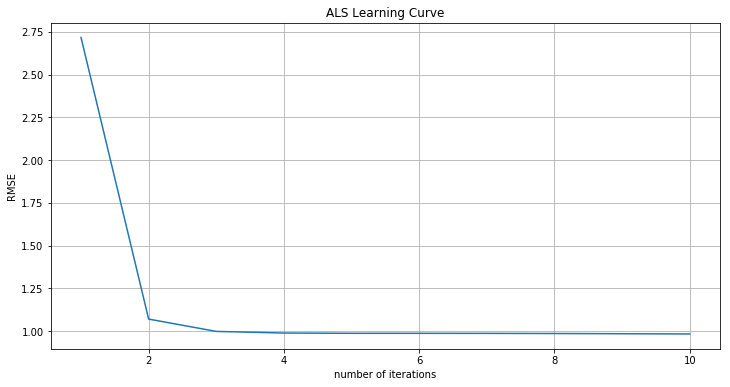

In [21]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.8

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [23]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8921


### Make movie recommendation to myself
We need to define a function that takes new user's movie rating and output top 10 recommendations

In [0]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite movies into the system. And then the system should output top N movie recommendations for me to watch

In [26]:
# my favorite movies
my_favorite_movies = ['Toy Story']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=15, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Toy Story:
1: Hoop Dreams (1994)
2: Shawshank Redemption, The (1994)
3: Silence of the Lambs, The (1991)
4: Wallace & Gromit: The Best of Aardman Animation (1996)
5: Philadelphia Story, The (1940)
6: It Happened One Night (1934)
7: It's a Wonderful Life (1946)
8: Wallace & Gromit: The Wrong Trousers (1993)
9: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
10: Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)
11: 12 Angry Men (1957)
12: Amadeus (1984)
13: Fantasia (1940)
14: General, The (1926)
15: Yojimbo (1961)


This list of movie recommendations look completely different than the list from my previous **KNN** model recommender. Not only it recommends movies outside of years between 2007 and 2009 periods, but also recommends movies that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular movies all the time.

So this list of recommendations can be blended into the previous list of recommendations from **KNN** model recommender